In [2]:
!pip install -Uqq fastbook duckduckgo_search 
!pip install jupyter_contrib_nbextensions
!pip install nbdev

import fastbook
fastbook.setup_book()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/gdrive


In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

In [7]:
search_images_bing
search_images_ddg

doc(search_images_ddg)

In [8]:
from duckduckgo_search import ddg_images
def search_images(term, max_images=150):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

#results = search_images('grizzly bear')
results = search_images_ddg('grizzly bear', max_images=150)
len(results)

150

In [9]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [10]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

In [12]:
Path('images/grizzly.jpg')

Path('images/grizzly.jpg')

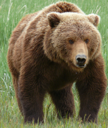

In [13]:
im = Image.open(dest)
im.to_thumb(128,128)

In [14]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

doc(Path)

In [17]:
#!rm -rf /kaggle/working/bears
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear', 150)
        print(results)
        download_images(dest, urls=results)

In [18]:
fns = get_image_files(path)
fns

(#291) [Path('bears/grizzly/1d7fa74c-d39b-4328-92ee-7b6d78788232.jpg'),Path('bears/grizzly/fad09ce8-0e20-4162-9d92-88db43e03e5b.jpg'),Path('bears/grizzly/db4336e2-9849-4250-a183-b34357c486c1.jpg'),Path('bears/grizzly/e502484a-cce6-4a29-84e8-2bd7a81a4ef1.jpg'),Path('bears/grizzly/2b3c6908-a106-4e3a-86d9-20d76a77d9c6.jpg'),Path('bears/grizzly/dc0555a5-c7b0-4e13-bf0c-4d1f07584156.jpg'),Path('bears/grizzly/7d16de54-4425-4f64-af3e-8ef370b7a80d.jpg'),Path('bears/grizzly/ebdb6421-5d33-48a5-b587-b5fb085ec801.jpg'),Path('bears/grizzly/70ba0895-dbfc-4682-8fcc-c57962589a55.jpg'),Path('bears/grizzly/b066caa2-d438-4a6b-b3a9-3a204b88ed8b.jpg')...]

In [19]:
??verify_images
failed = verify_images(fns)
failed

(#7) [Path('bears/grizzly/1d7fa74c-d39b-4328-92ee-7b6d78788232.jpg'),Path('bears/grizzly/30db0771-9dea-42fc-8133-daf0563124ac.jpg'),Path('bears/grizzly/24a9f4a7-4ca6-4fb1-85d6-711b1d24cb8a.jpeg'),Path('bears/grizzly/9e736d63-9e45-4584-a7d3-6b96b739cf1b.jpg'),Path('bears/black/b109bbe3-bda7-4389-bbad-d884d0fe4092.jpg'),Path('bears/black/103008fb-610a-468c-a4cc-bb54f2e0369b.jpg'),Path('bears/black/4e744d4f-e2b8-4a1a-8276-dc41e8542e97.jpg')]

In [20]:
failed.map(Path.unlink);

In [21]:
??verify_images

In [23]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [24]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

doc(DataBlock)

In [25]:
blocks=(ImageBlock, CategoryBlock)

In [26]:
get_items=get_image_files

In [27]:
splitter=RandomSplitter(valid_pct=0.2, seed=42)

In [28]:
get_y=parent_label

In [29]:
item_tfms=Resize(128)

In [30]:
# Create a DataLoaders object from source
dls = bears.dataloaders(path)

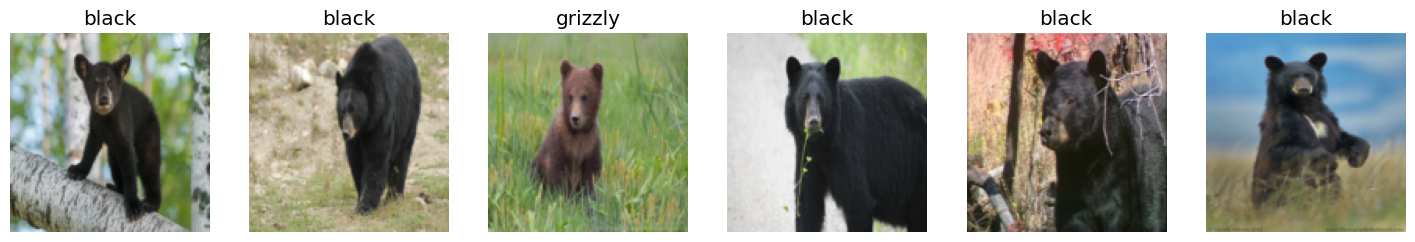

In [37]:
dls.valid.show_batch(max_n=6, nrows=1)

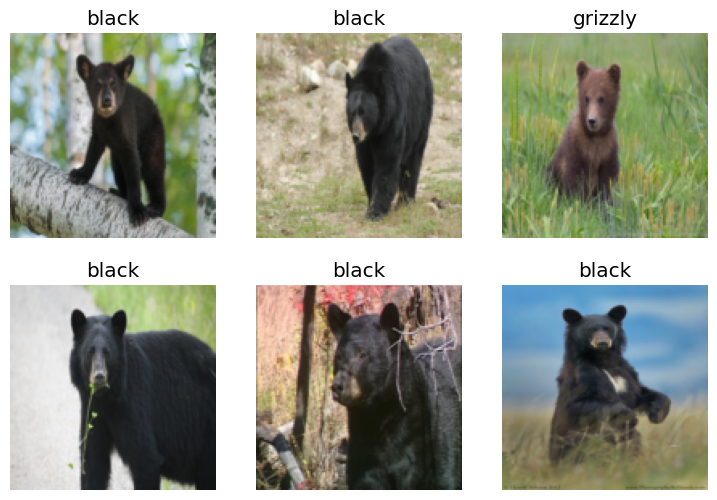

In [38]:
doc(bears.new)
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=6, nrows=2)

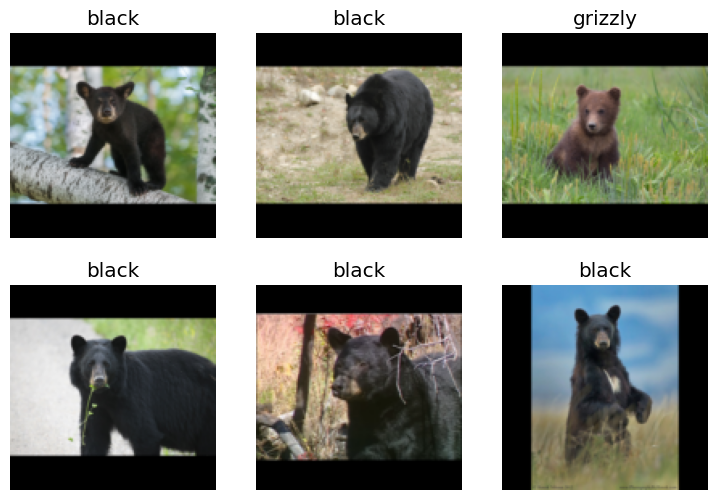

In [40]:
doc(bears.new)
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=6, nrows=2)


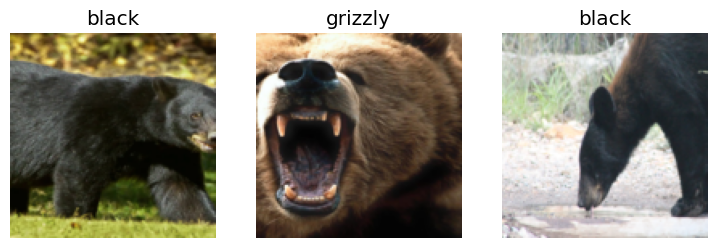

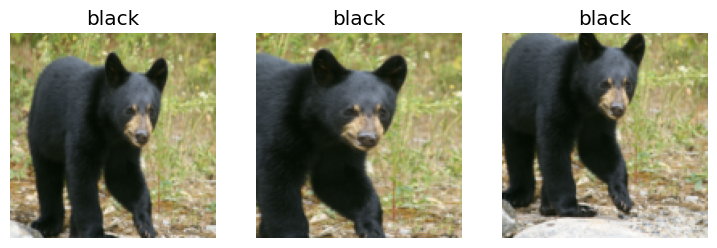

In [41]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)

doc(dls.train.show_batch)

# unique 會使用同張照片
dls.train.show_batch(max_n=3, nrows=1)
dls.train.show_batch(max_n=3, nrows=1, unique=True)

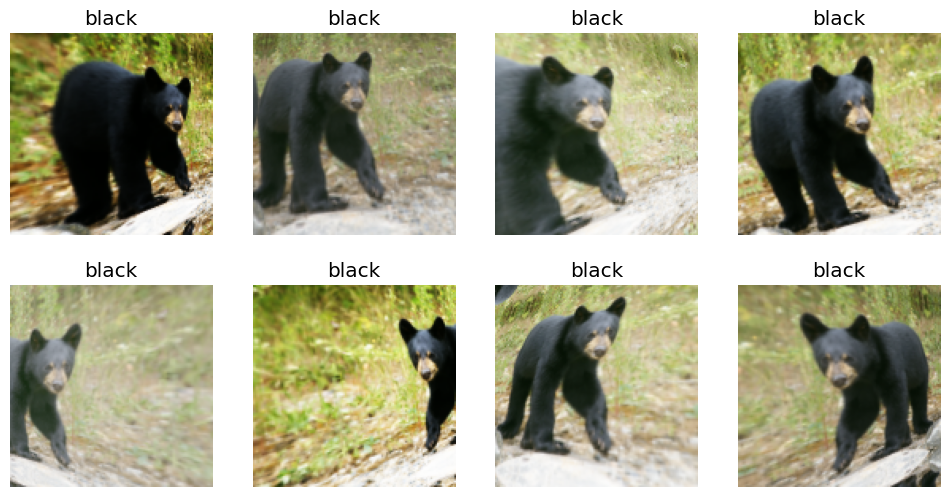

In [43]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [44]:
bears = bears.new(
    item_tfms=RandomResizedCrop(128, min_scale=0.3),
    batch_tfms=aug_transforms())


dls = bears.dataloaders(path)

#dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [45]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.2MB/s]


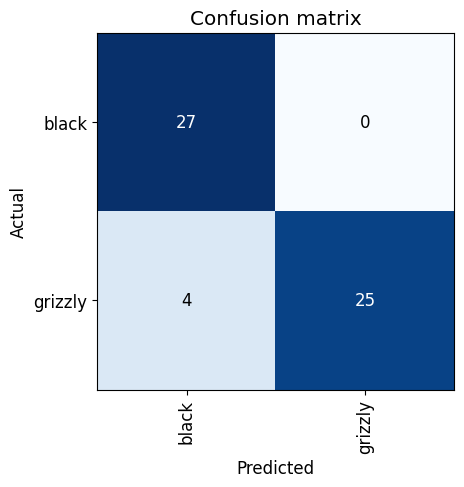

In [46]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

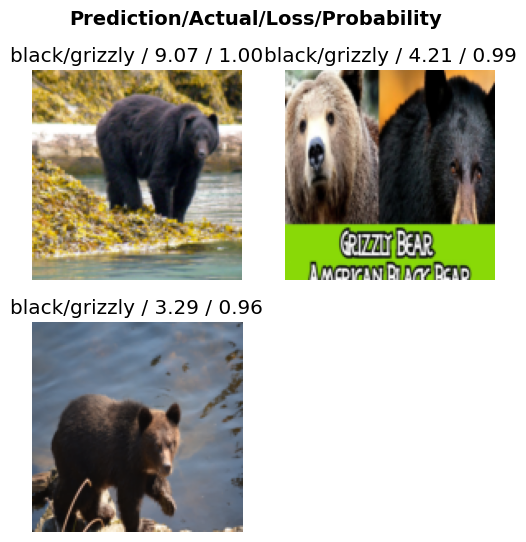

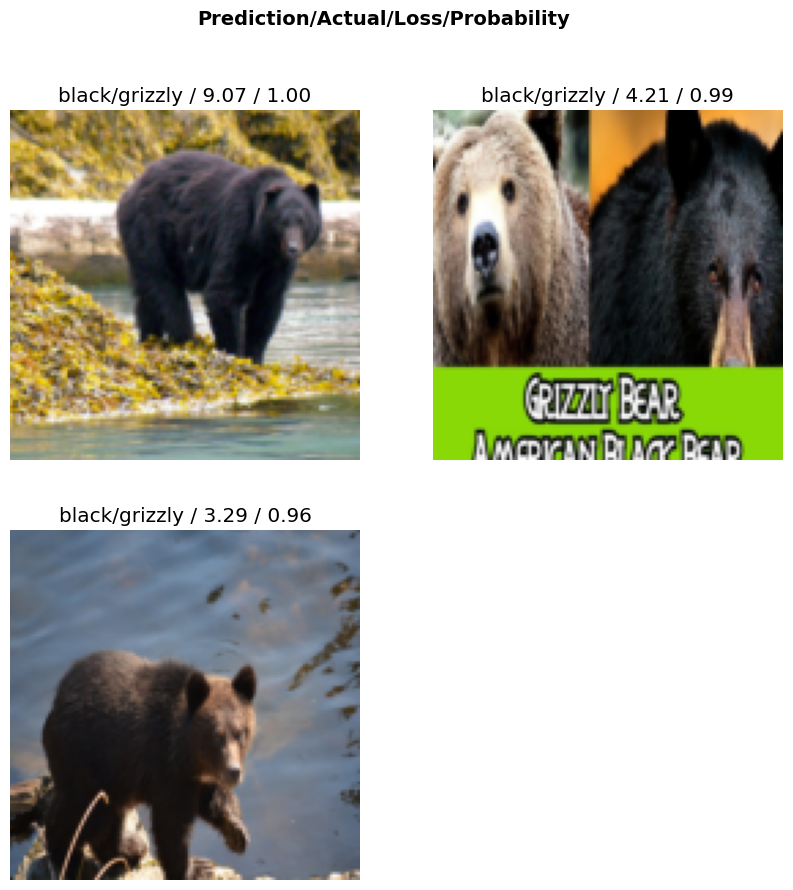

In [47]:
interp.plot_top_losses(3, nrows=2)

doc(interp.plot_top_losses)
??interp.plot_top_losses

# According to the matplot docs it’s the image size in inches.
interp.plot_top_losses(3, nrows=2, figsize=(10,10))

In [48]:
#doc(ImageClassifierCleaner)
cleaner = ImageClassifierCleaner(learn)
cleaner

In [49]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [50]:
learn.export()

In [51]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [52]:
learn_inf = load_learner(path/'export.pkl')

In [53]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([3.2563e-05, 9.9997e-01]))

In [54]:
learn_inf.dls.vocab

['black', 'grizzly']

In [65]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [66]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [67]:
img = PILImage.create(btn_upload.data[-1])

In [68]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [69]:
pred,pred_idx,probs = learn_inf.predict(img.resize((128,128)))

In [70]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9999')

In [71]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [72]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [74]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [75]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])